In [1]:
#
from glob import glob as gg
#
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc as rc
#
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
#
from netCDF4 import Dataset  
#
from datetime import datetime
from datetime import date
#
import pandas as pd
#
import gsw
#
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,LatitudeLocator)

In [16]:
# load ITP_ocean data
class sensor:
    def __init__(self, dates, longitude, latitude, pressure, temperature, salinity):
        # pressure as a proxy for depth
        self.pressure = pressure
        
        # crop according to dates and compute daily (means) values
        ind=np.where(dates>0)[0]
        self.compute_daily_values(dates[ind], longitude[ind], latitude[ind], temperature[:,ind], salinity[:,ind])
        
        # compute depth from pressure and latitude
        self.compute_depth()
    
    def compute_daily_values(self, time, lon, lat, T, S):
        # sort dates (daily)
        dates, indices = np.unique(np.floor(time), return_inverse=True)
        
        # compute daily values
        longitude, latitude, temperature, salinity = [], [], [], []
        for i in range(len(dates)):
            ind = np.where(indices==i)[0]
            #print (ind)
            # longitude, latitude, temperature, salinity
            tmp1, tmp2 = np.nanmean(lon[ind]), np.nanmean(lat[ind])
            tmp3, tmp4 = np.nanmean(T[:,ind],-1), np.nanmean(S[:,ind],-1)
            longitude.append(tmp1), latitude.append(tmp2), temperature.append(tmp3), salinity.append(tmp4)
            
            # store data
            self.dates = dates
            self.longitude, self.latitude = np.asarray(longitude), np.asarray(latitude)
            self.temperature, self.salinity = np.asarray(temperature), np.asarray(salinity)
            
    def compute_depth(self):
        
        depth = []
        for lat in self.latitude:
            tmp = gsw.z_from_p(self.pressure, lat)
            depth.append(gsw.z_from_p(self.pressure, lat))
        self.depth = np.asarray(depth)
        
class ocean_data:
    def __init__(self):
        self.read_ocean_data()
        
    def read_ocean_data(self):
        # load .mat files
        path_obs = '/home/fbirrien/Data/Observations/MOSAiC/ocean/'
        filename = path_obs + 'mosaic.whoiitpmerged.newgrid.mat'
        matdata = loadmat(filename)
    
        # dates (time axis)
        dates = matdata['julds']-366.
                
        # coordinates
        longitude, latitude = matdata['lons'], matdata['lats']
        
        # pressure (depth axis)
        pressure = matdata['pressg'][0]
        
        # salinity amd temperature
        salinity, temperature = matdata['salg'],matdata['ptmpg']

        # sensor 1: ITP92 
        sensor1 = sensor(dates[:,0], longitude[:,0], latitude[:,0], pressure, temperature[:,:,0], salinity[:,:,0])
        # sensor 2: ITP101
        sensor2 = sensor(dates[:,1], longitude[:,1], latitude[:,1], pressure, temperature[:,:,1], salinity[:,:,1])
        # sensor 3: ITP112
        sensor3 = sensor(dates[:,-1], longitude[:,-1], latitude[:,-1], pressure, temperature[:,:,-1], salinity[:,:,-1])
        
        # store data
        self.sensor1, self.sensor2, self.sensor3 = sensor1, sensor2, sensor3
#
ITP_data =  ocean_data()

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Wed May 26 19:48:09 2021', '__version__': '1.0', '__globals__': [], 'ans': array(['07-Oct-2019 13:02:02', '08-Oct-2019 00:02:00',
       '08-Oct-2019 06:02:00', '08-Oct-2019 12:02:00',
       '08-Oct-2019 18:02:01', '09-Oct-2019 00:02:00',
       '09-Oct-2019 06:02:00', '09-Oct-2019 12:02:00',
       '09-Oct-2019 18:02:00', '10-Oct-2019 00:02:00',
       '10-Oct-2019 06:02:00', '10-Oct-2019 12:02:00',
       '10-Oct-2019 18:02:00', '11-Oct-2019 00:02:00',
       '11-Oct-2019 06:02:01', '11-Oct-2019 12:02:00',
       '11-Oct-2019 18:02:00', '12-Oct-2019 00:02:00',
       '12-Oct-2019 06:02:00', '12-Oct-2019 12:02:00',
       '12-Oct-2019 18:02:00', '13-Oct-2019 00:02:00',
       '13-Oct-2019 06:02:00', '13-Oct-2019 12:02:00',
       '13-Oct-2019 18:02:01', '14-Oct-2019 00:02:00',
       '14-Oct-2019 06:02:00', '14-Oct-2019 12:02:00',
       '14-Oct-2019 18:02:00', '15-Oct-2019 00:02:00',
       '15-Oct-2019 06:02:00', '

/tmp/ipykernel_16691/309884248.py:25: RuntimeWarning: Mean of empty slice
  tmp3, tmp4 = np.nanmean(T[:,ind],-1), np.nanmean(S[:,ind],-1)


In [3]:
class Trajectory_Polarstern:
    def __init__(self):
        self.read_trajectory()

    def read_trajectory(self):
        path_traj = '/home/fbirrien/Data/Observations/MOSAiC/data/original_tracks/' 
        filename = path_traj + 'Polarstern_trajectory.nc'
        ncid = Dataset(filename, "r", format="NETCDF4")
        self.dates = ncid['dates'][:]
        self.longitude, self.latitude = ncid['longitude'][:], ncid['latitude'][:]
        ncid.close()

# load MOSAiC trajectories
#
trajectory = Trajectory_Polarstern()

In [4]:
class mesh_data:
    def __init__(self, filename):
        self.read_vertical_mesh(filename)
        
    def read_vertical_mesh(self,filename):
        ncid = Dataset(filename, "r", format="NETCDF4")        
        
        # read dates 
        self.dates = ncid.variables['dates'][:]
        
        # read vertical mesh
        self.nlevels, self.Z = ncid.variables['nlevels'][:]-1, ncid.variables['Z'][:]
        ncid.close()
#
# read mesh information
#
path_mesh = '/home/fbirrien/NuArctic/nuarctic/REcoM1D/grid/'
filename = path_mesh + 'REcoM1D_daily_mesh.nc'
mesh = mesh_data(filename)

In [5]:
#  
#  plot
#
def define_map():
    fig = plt.figure(figsize=(14, 14))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.coastlines(resolution='10m');
    #ax.stock_img()
    gl=ax.gridlines(draw_labels=True, dms=False)
    gl.xlabel_style = {'color': 'navy', 'weight': 'bold', 'size': 18}
    gl.ylabel_style = {'color': 'gainsboro', 'weight': 'bold', 'size': 18}
    gl.ylabel_style = {'color': 'gainsboro', 'weight': 'bold', 'size': 0}
    gl.ylocator = LatitudeLocator()
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    return(fig, ax)

296 (296, 801) (296, 801)


/tmp/ipykernel_16691/2855485493.py:25: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax[0].pcolor(D,data.depth, data.temperature)
/tmp/ipykernel_16691/2855485493.py:31: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax[1].pcolor(D, data.depth, data.salinity)


113 (113, 801) (113, 801)
304 (304, 801) (304, 801)


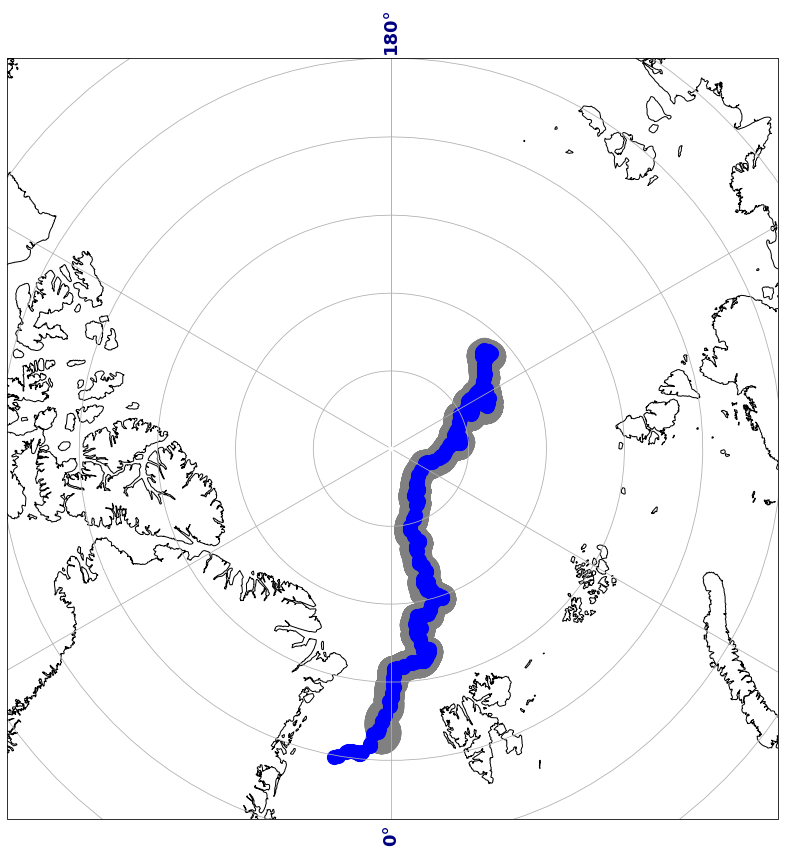

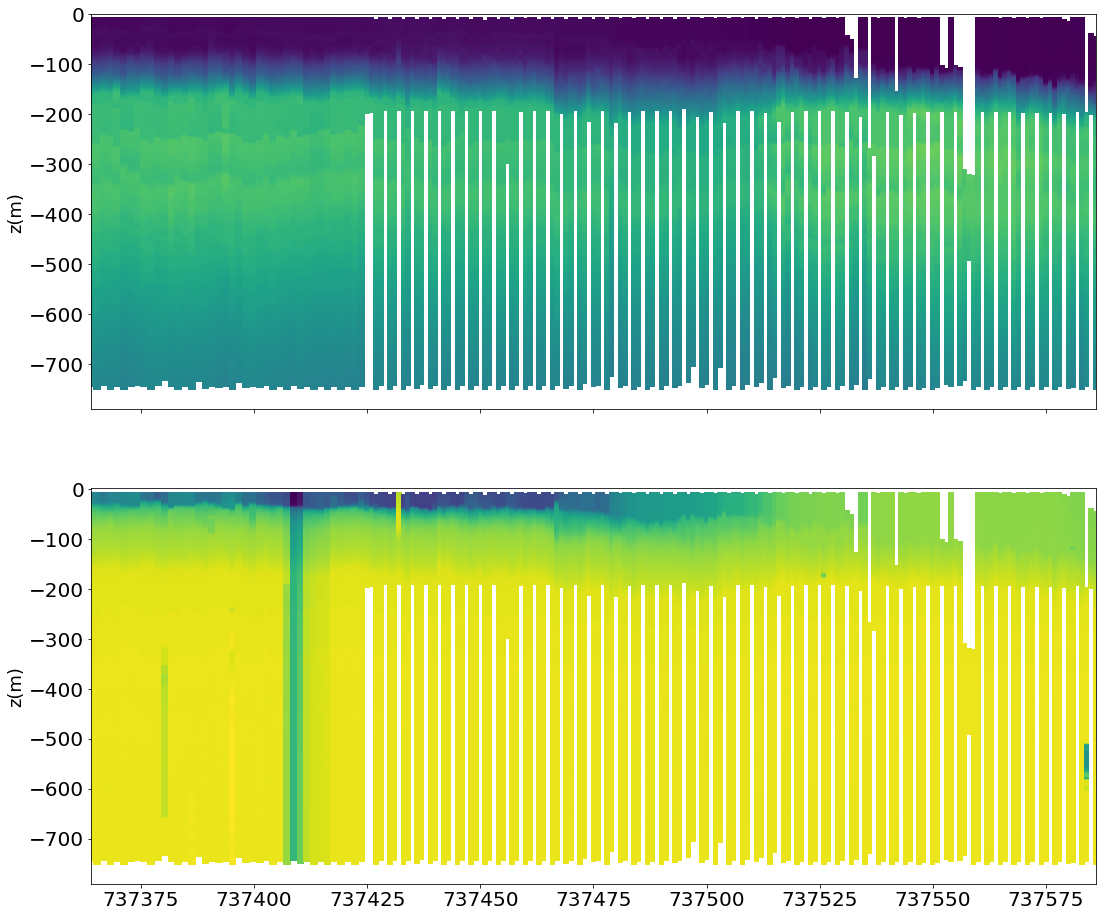

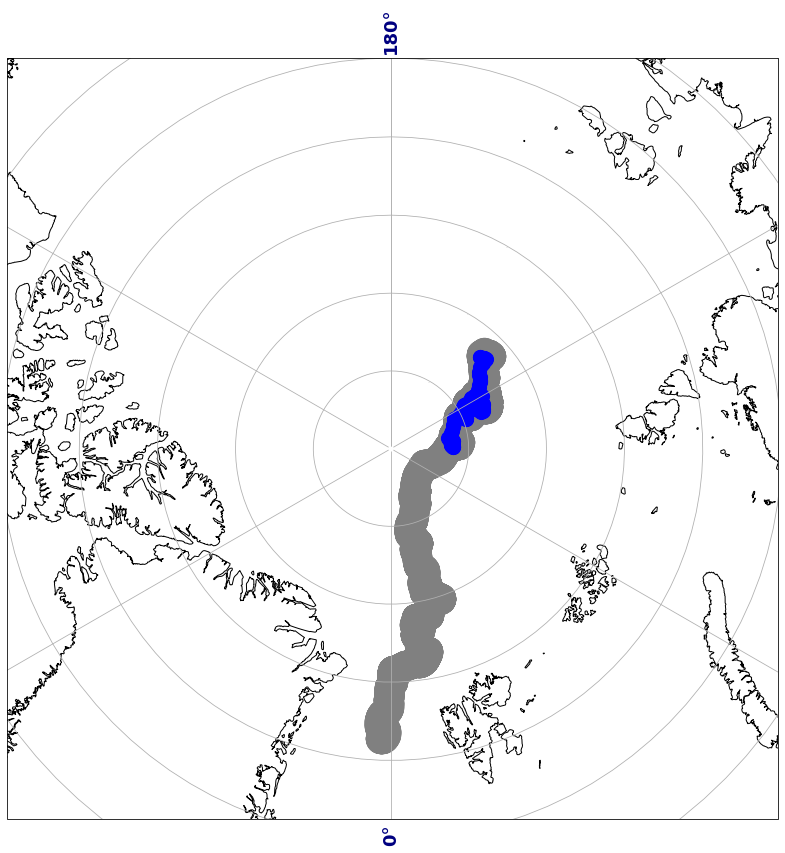

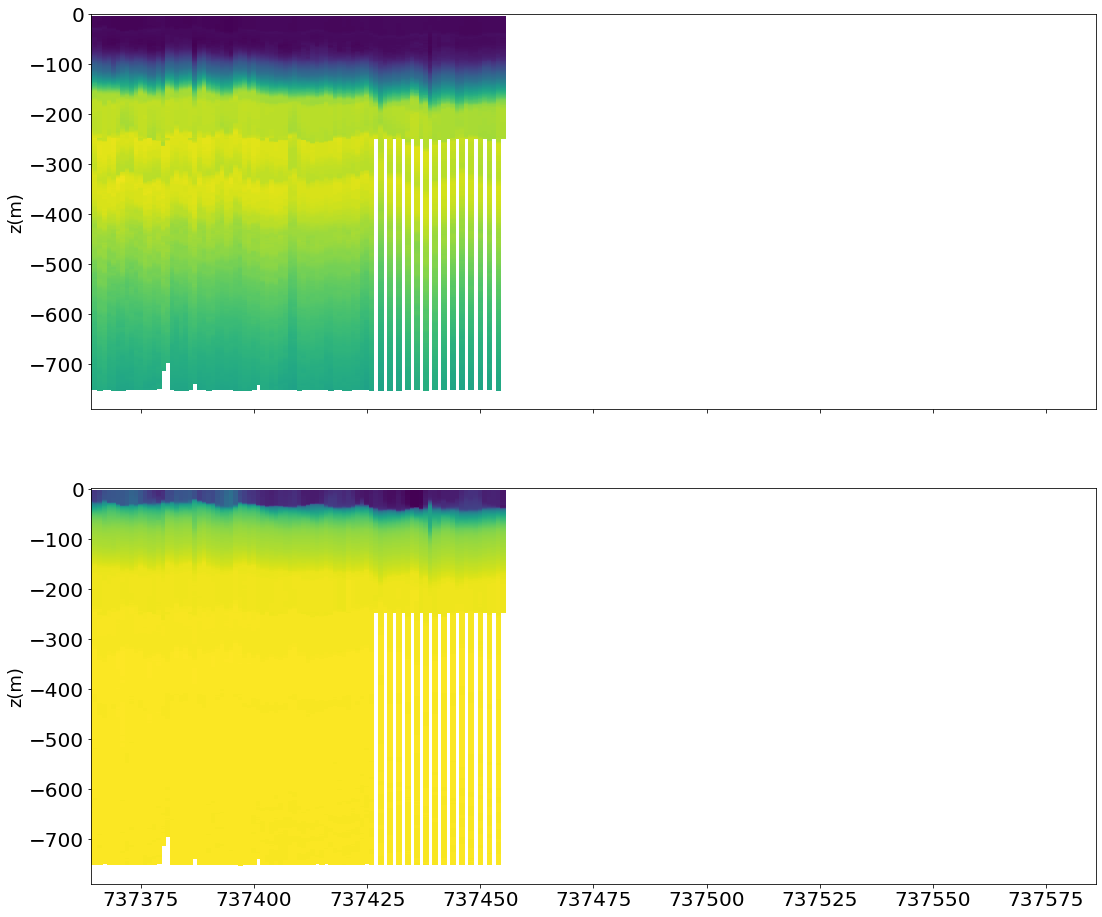

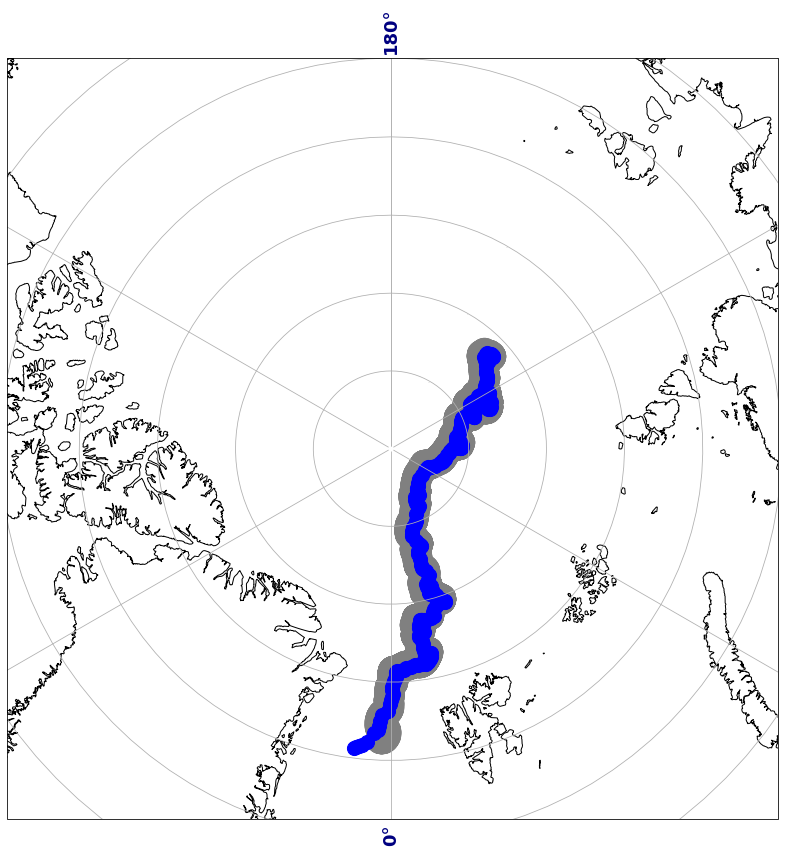

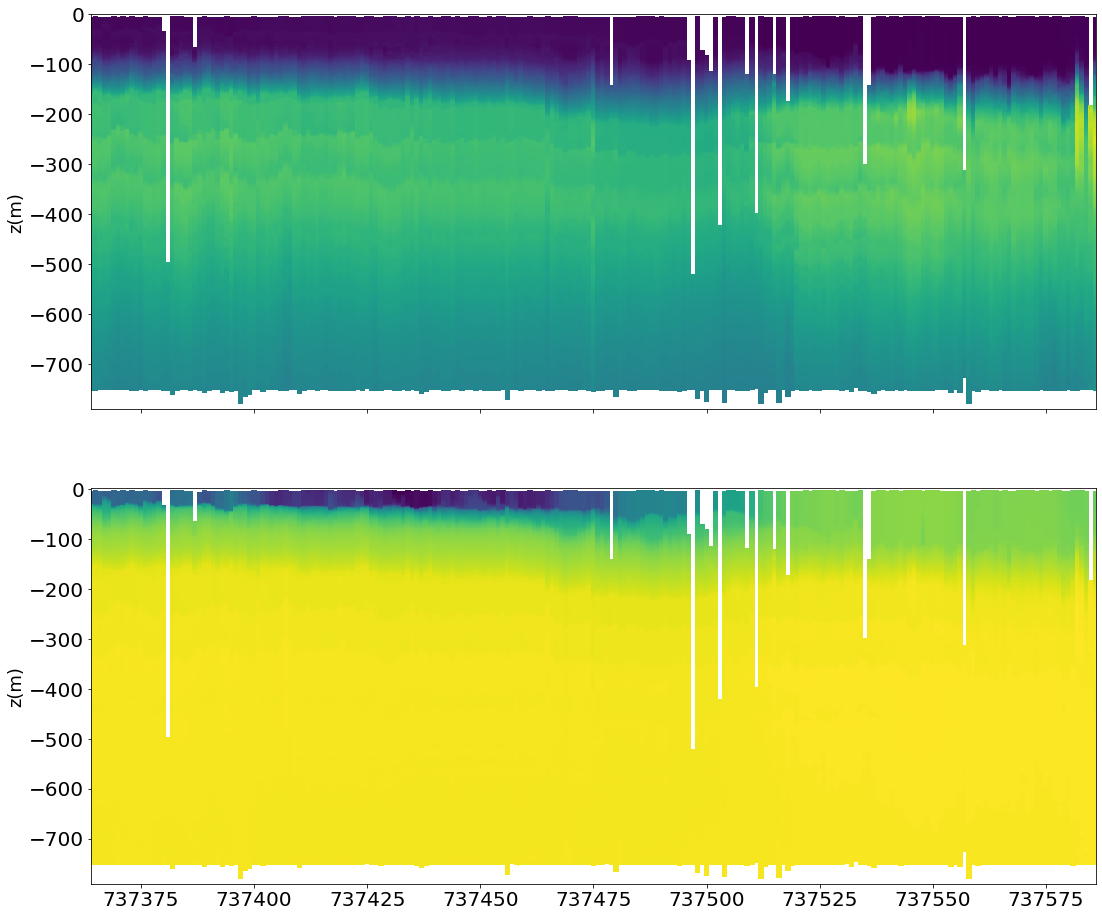

In [6]:
tl = [np.min(mesh.dates), np.max(mesh.dates)]

def plot_sensor_map(trajectory, data):
    Proj = ccrs.PlateCarree()
    fig, ax = define_map()
    plot_extent = [-180, 180, 75, 90]
    ax.set_extent(plot_extent, crs=Proj)
    lbsz, tcsz, mksz = 30, 20, 20
    rc('xtick', labelsize=tcsz) , rc('ytick', labelsize=tcsz)
    # trajectory of the Polarstern
    var=trajectory
    ax.scatter(var.longitude, var.latitude, c='0.5', s=800, transform=Proj)
    # trajectory of the sensor
    var=data
    ax.scatter(var.longitude, var.latitude, c='b', s=200, transform=Proj)
    
def plot_variables(data):
    fsz = (18,16)
    fig,ax = plt.subplots(2, sharex=True, figsize=fsz)
    print(len(data.dates), data.depth.shape, data.salinity.shape)
    # temperature
    D, nt, npd =np.zeros(data.temperature.shape), len(data.dates), data.temperature.shape[1]
    for i in range(npd):
        D[:,i] = data.dates
    ax[0].pcolor(D,data.depth, data.temperature)
    ax[0].axvline(x=737587)
    ax[0].set_xlim(tl)
    ax[0].set_ylabel('z(m)', fontsize=18)
    
    # salinity
    ax[1].pcolor(D, data.depth, data.salinity)
    ax[1].set_xlim(tl)
    ax[1].set_ylabel('z(m)', fontsize=18)
    
def plot_sensor_data(trajectory, data):
    # plot drift map
    plot_sensor_map(trajectory, data)
    
    # plot temperature and salinity
    plot_variables(data)
#
# ITP 94
data=ITP_data.sensor1
plot_sensor_data(trajectory, data)

# ITP 102
data=ITP_data.sensor2
plot_sensor_data(trajectory, data)

# ITP 111
data=ITP_data.sensor3
plot_sensor_data(trajectory, data)

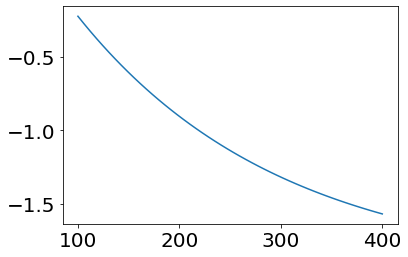

In [108]:
x=np.linspace(100,400)
tmin,Tf = 0.9031464648684091, -1.955631808275761
y= tmin - (tmin-Tf)*(1-np.exp(-0.005*x))
fig,ax = plt.subplots(1)
ax.plot(x,y)

In [155]:
#def func(x, a, b, c):
#    y = b - (b-c) *(1-np.exp(-a*(x-x[0])))
#    return y

#def wrapperfunc(tmin,Tf):
#    def tempfunc(x, a, tmin, Tf):
#        return func(x, a, tmin, Tf)
#    return tempfunc

# 
# perform vertical interpolation
#
#salinity
def extrapolate_salinity_surface(inp):
    outp = np.copy(inp)
    ind = np.where(np.isnan(outp[:10]))[0]
    #extend linearly to the surface
    outp[ind] = 2*outp[ind+1] - outp[ind+2]
    return outp
    
def extrapolate_salinity_high_depth(inp):
    outp = np.copy(inp)
    ind = np.where(np.isnan(outp))[0]
    sp = outp[ind[0]-1]
    outp[ind] = sp
    
    return outp

#temperature
def extrapolate_temperature_surface(inp):
    outp = np.copy(inp)
    ind = np.where(np.isnan(outp[:10]))[0]
    if len(ind)<2:
                #extend linearly to the surface
                outp[ind] = outp[ind+1]
    return outp
#def exp    
def extrapolate_temperature_high_depth(inp,method, depth=[], D=[], T=[], tmin=[], Tf=[], zref=-500):
    outp = np.copy(inp)
    thr=1e-5
    ind = np.where(np.isnan(inp[:]))[0]
    if method=='linear':
        for i in ind:
            outp[i] = 2*outp[i-1] - outp[i-2]
            
    elif method=='exponential':

       
        # computation indices indices 
        # data
        ind, indnan = np.where(D<zref)[0], np.where(~np.isnan(T))[0]
        indices = list(set(ind) & set(indnan)) 
        x1, y1 = abs(D[indices]), T[indices]
        # gridded
        index = np.where(depth<zref)[0]
        x2 = abs(depth[index]) 
        # exponential decay to be fitted
        def func(x,a):
            y = tmin - (tmin-Tf) *(1- np.exp(-a*(x-x1[0])))
            return y
        
        # fit function to data
        popt, pcov = curve_fit(func, x1, y1)
        y2 = func(x2,*popt)
        #store data
        outp[index] = y2
        
    return outp

def compute_freezing_temperature(salinity):
    a = -18.48
    b = -a/1000.
    
    Tf = salinity/(a + b * salinity)
    
    return Tf


class vertical_interpolation:
    def __init__(self, data, mesh):
        self.perform_vertical_interpolation(data, mesh)
        
    def perform_vertical_interpolation(self,data, mesh):
        # initialization
        self.dates, self.depth = mesh.dates, mesh.Z
        nt, nz = len(mesh.dates), len(mesh.Z)
        temperature, salinity = np.zeros((nt,nz))*np.nan, np.zeros((nt,nz))*np.nan
        indsal, indtemp = [], []
        # vertical interpolation according to bathymetry
        flagplot=False
        dat = mesh.dates[:30] if flagplot else mesh.dates
        
        for i, dt in enumerate(dat):
            # vertical level
            nl = int(mesh.nlevels[i])
            Z = [z for z in mesh.Z[:nl]]
            
            # find corresponding time in data
            indt = np.where(abs(data.dates-dt)<1e-3)[0]
            datad, datas, datat = data.depth[indt][0], data.salinity[indt][0], data.temperature[indt][0]
            
            # perform interpolation
            # salinity
            f=interp1d(datad, datas, fill_value='extrapolate')
            sal = f(Z)
            # temperature
            f=interp1d(datad,datat, fill_value='extrapolate')
            temp=f(Z)
    
            # process gap in salinity
            # idea: - interpolate on the 1st meters
            #       - extend linearly (same value) in high depth
            #       - test if data are sufficient in the profile 
            #         otherwise leave NaN that will be interpolated temporally
            # extend linearly to the surface
            ind = np.where(np.isnan(sal[:10]))[0]
            if len(ind)<2:
                #extend linearly to the surface
                sal = extrapolate_salinity_surface(sal)
                
                # extend linearly to high depth
                sal = extrapolate_salinity_high_depth(sal)

            else:
                indsal.append(i)
                #sal[:]=np.nan

            # estimate freezing temperature from salinity
            Tf = compute_freezing_temperature(sal[-1])
            print(Tf)
            
            # process gap in temperature
            # idea : - extend linearly in the first meters
            #        - 
            #
            ind = np.where(np.isnan(temp[:10]))[0]
            if len(ind)<2:
                dref = - 500
                #extend linearly to the surface
                temp = extrapolate_temperature_surface(temp)
                # extend linearly to high depth
                #temp = extrapolate_temperature_high_depth(temp,'linear')
                tmin = datat[np.where(datad<=dref)[0][0]]
                temp = extrapolate_temperature_high_depth(temp,'exponential', self.depth[:nl], datad, datat, tmin, Tf, dref)
                
            else:
                indtemp.append(i)
                #temp[:] = np.nan
                

            # plot
            if (flagplot):
                fig,ax = plt.subplots(1, 2, sharey=True)
                # salinity
                ax[0].plot(datas, datad, label='measured', lw=8)
                ax[0].plot(sal, Z, label='interpolated')
                ax[0].grid(), ax[0].legend(), ax[0].set_ylim([-2000,0])
                #temperature
                ax[1].plot(datat, datad, label='measured', lw=8)
                ax[1].plot(temp, Z, label='interpolated')
                ax[1].axvline(x=Tf, ls='--', color = 'k')
                ax[1].grid(), ax[1].legend(), ax[1].set_xlim([-2,2])
           
            # store data
            salinity[i,:nl], temperature[i,:nl] = sal, temp
            
        self.salinity, self.temperature = salinity, temperature
        self.indtemp, self.indsal = indtemp, indsal
#
# process ITP 111
data=ITP_data.sensor3
data_IV = vertical_interpolation(data,mesh)

-1.955631808275761
-1.9556560788927533
-1.9556305928024182
-1.9555547692309672
-1.9556179830844542
-1.955706793980869
-1.9557131358221762
-1.9557253874602756
-1.9557420390734286
-1.9557399813508385
-1.9557709510811174
-1.9557712673889112
-1.955662198880603
-1.9556861974482103
-1.9556376950354266
-1.955601966875307
nan
nan
-1.9554920666264501
-1.9556263121127484
-1.9556698020208132
-1.9555710240759931
-1.9555555417631816
nan
nan
-1.9556790321371993
-1.9556718490951812
-1.955702972782142
-1.9557508215851918
-1.9556726615901652
-1.9557111889021495
-1.9556945023145849
-1.955776564909357
-1.95582980361754
-1.9557671760404485
-1.955714533763308
-1.9556287373852013
-1.9555893443207029
-1.9555651777955234
-1.9556317661613738
-1.9555633063725872
-1.95563709936647
-1.9555674953944968
-1.9554067029481519
-1.9556226180040677
-1.9555531290447539
-1.9556012319935427
-1.9555930245858313
-1.955551829897083
-1.9555116189436232
-1.9556030911132245
-1.9556655187212086
-1.9556520055926978
-1.9556718177276

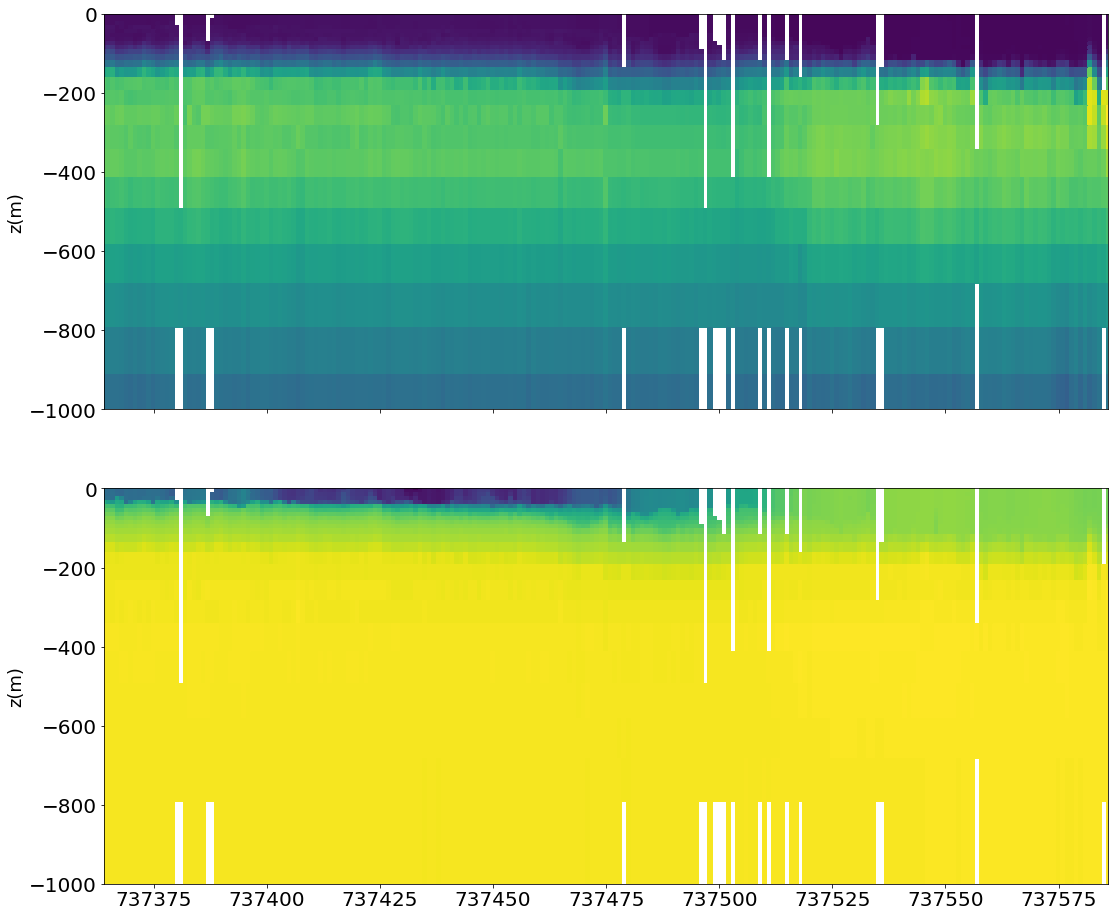

In [162]:
# plot_map
def plot_variables_map(var):
    fsz = (18,16)
    dl = [-1000, 0]
    fig,ax = plt.subplots(2, sharex=True, figsize=fsz)

    # temperature
    ax[0].pcolor(var.dates, var.depth, var.temperature.T)
    #ax[0].pcolor(var.temperature)
    ax[0].set_ylim(dl), ax[0].set_ylabel('z(m)', fontsize=18)
    
    # salinity
    ax[1].pcolor(var.dates, var.depth, var.salinity.T)
    #ax[1].pcolor(var.salinity.T)
    ax[1].set_xlim(tl)
    ax[1].set_ylim(dl), ax[1].set_ylabel('z(m)', fontsize=18)

#
var= data_IV
plot_variables_map(var)

/tmp/ipykernel_16691/31023215.py:13: RuntimeWarning: Mean of empty slice
  msal = np.nanmean(var.salinity[jind,:],0)
/tmp/ipykernel_16691/31023215.py:13: RuntimeWarning: Mean of empty slice
  msal = np.nanmean(var.salinity[jind,:],0)
/tmp/ipykernel_16691/31023215.py:13: RuntimeWarning: Mean of empty slice
  msal = np.nanmean(var.salinity[jind,:],0)
/tmp/ipykernel_16691/31023215.py:13: RuntimeWarning: Mean of empty slice
  msal = np.nanmean(var.salinity[jind,:],0)
/tmp/ipykernel_16691/31023215.py:13: RuntimeWarning: Mean of empty slice
  msal = np.nanmean(var.salinity[jind,:],0)
/tmp/ipykernel_16691/31023215.py:13: RuntimeWarning: Mean of empty slice
  msal = np.nanmean(var.salinity[jind,:],0)
/tmp/ipykernel_16691/31023215.py:13: RuntimeWarning: Mean of empty slice
  msal = np.nanmean(var.salinity[jind,:],0)
/tmp/ipykernel_16691/31023215.py:13: RuntimeWarning: Mean of empty slice
  msal = np.nanmean(var.salinity[jind,:],0)
/tmp/ipykernel_16691/31023215.py:13: RuntimeWarning: Mean of emp

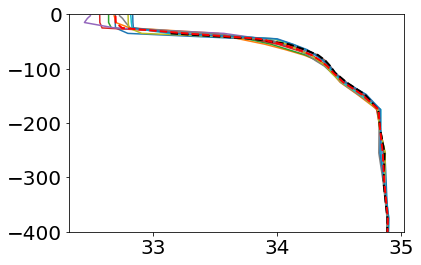

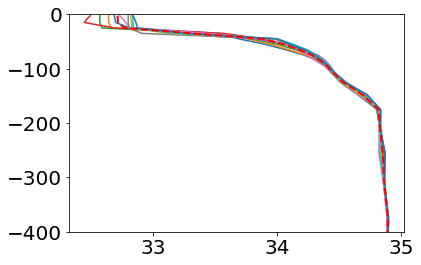

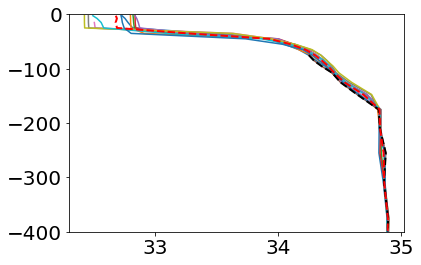

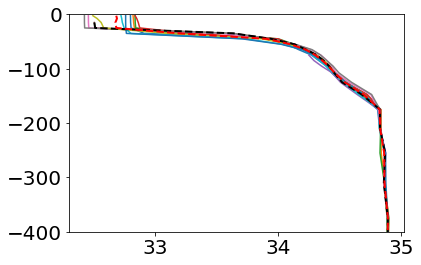

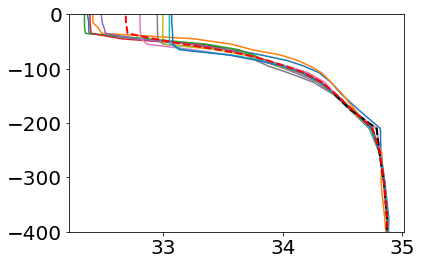

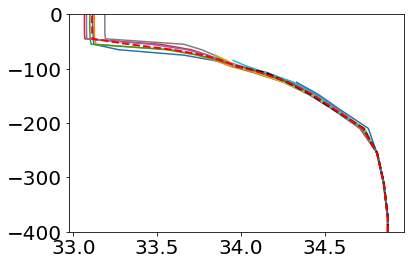

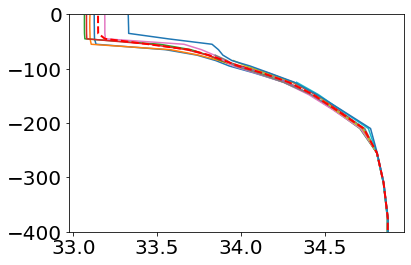

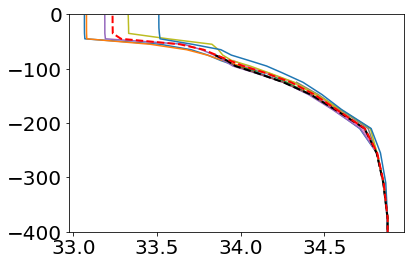

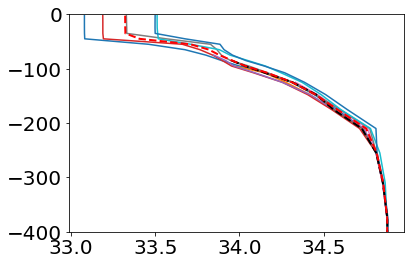

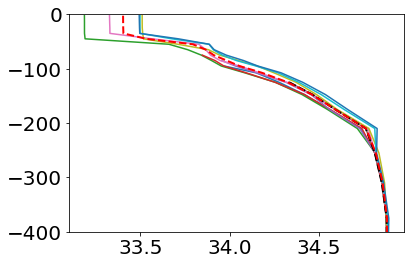

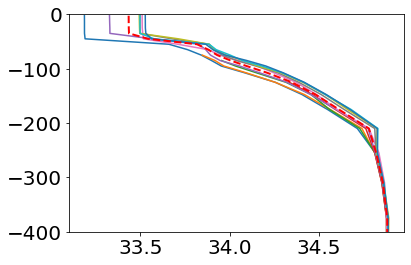

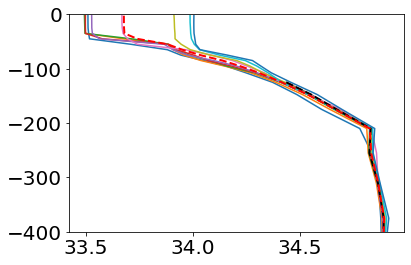

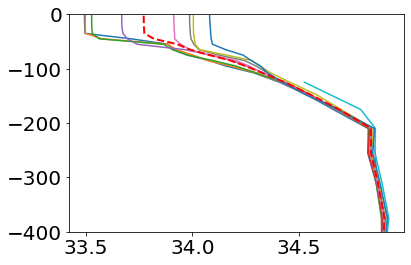

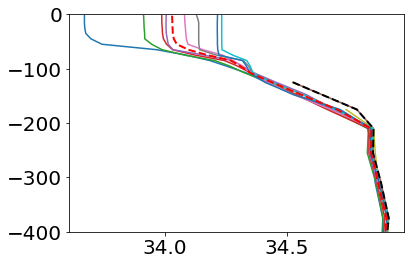

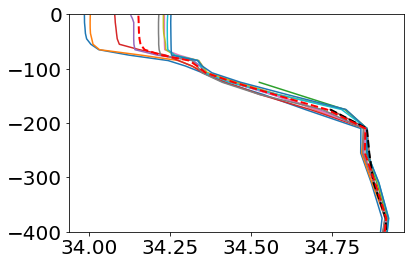

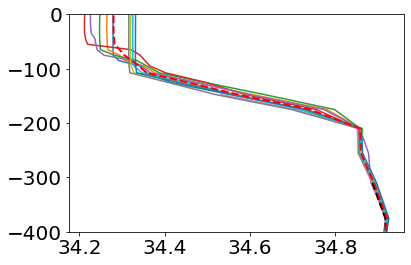

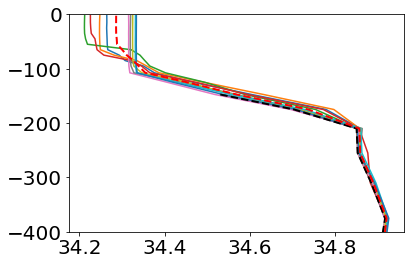

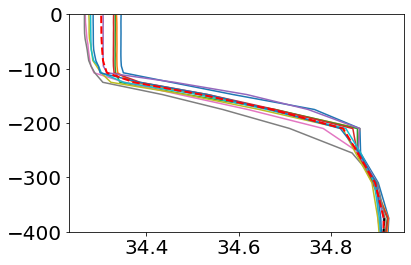

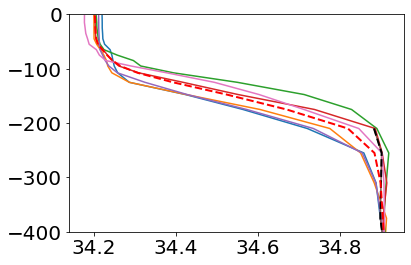

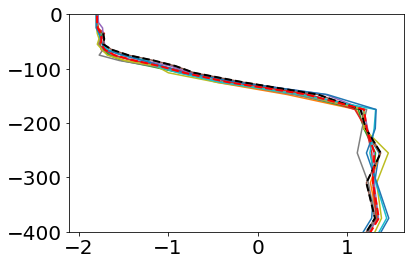

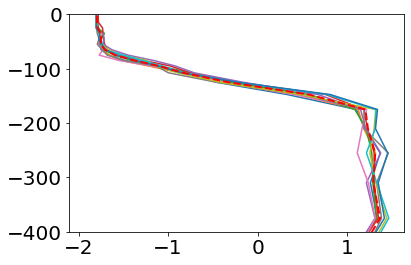

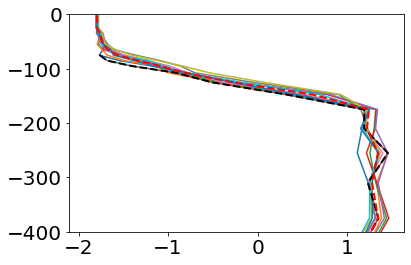

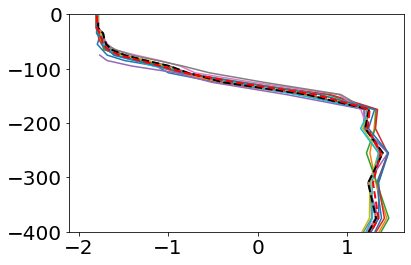

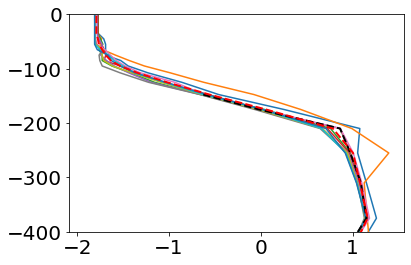

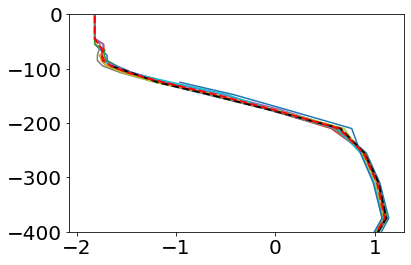

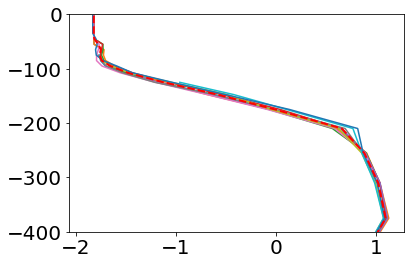

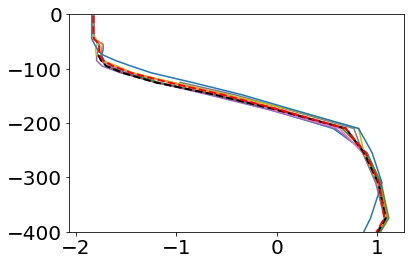

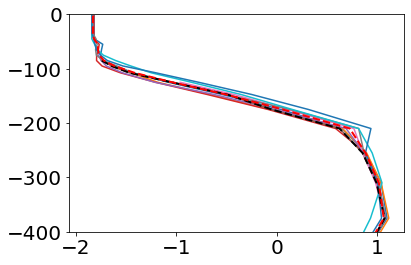

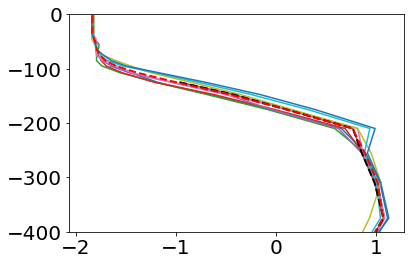

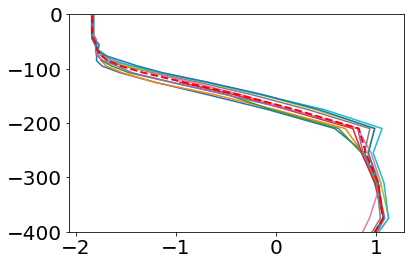

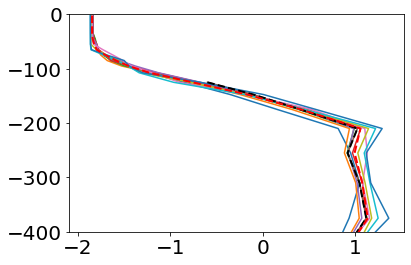

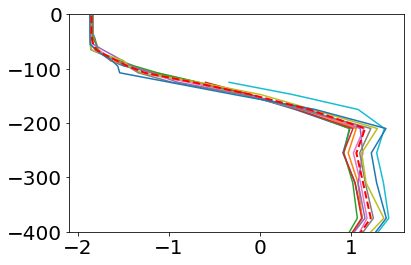

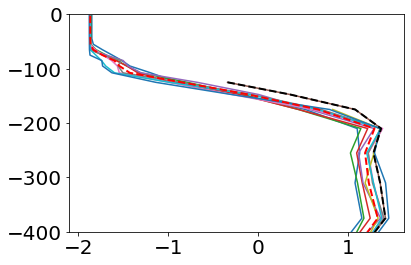

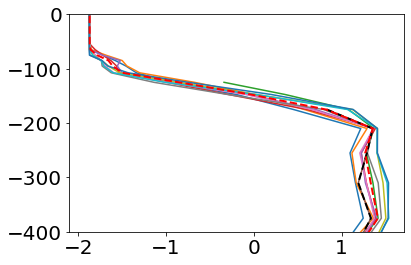

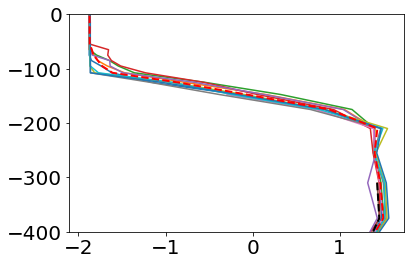

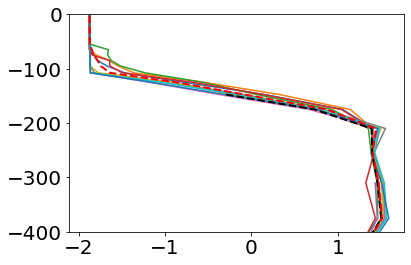

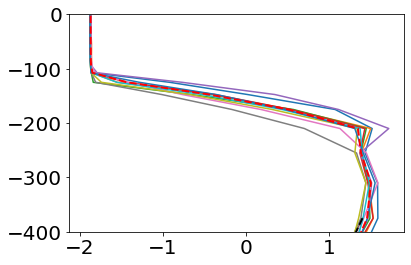

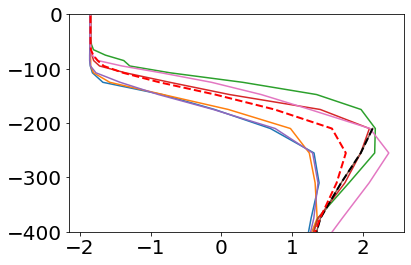

In [157]:
# process salinity  and temperature outliers
# idea : temporal moving average on a given window
# here only visualization
var = data_IV
win=5
nt = len(var.dates)
for i in var.indsal:
    fig, ax = plt.subplots(1)
    ind1, ind2 = np.max([0, i-win]), np.min([i+win,nt-1])
    jind = np.linspace(ind1,ind2, ind2-ind1+1).astype(int)
    for j in jind:
        ax.plot(var.salinity[j,:], var.depth)
    msal = np.nanmean(var.salinity[jind,:],0) 
    ax.plot(var.salinity[i,:], var.depth, ls='--', color='k',lw=2)
    ax.plot(msal, var.depth, ls='--', color='r',lw=2)
    ax.set_ylim([-400,0])

for i in var.indtemp:
    fig, ax = plt.subplots(1)
    ind1, ind2 = np.max([0, i-win]), np.min([i+win,nt-1])
    jind = np.linspace(ind1,ind2, ind2-ind1+1).astype(int)
    for j in jind:
        ax.plot(var.temperature[j,:], var.depth)
    mtemp = np.nanmean(var.temperature[jind,:],0) 
    ax.plot(var.temperature[i,:], var.depth, ls='--', color='k',lw=2)
    ax.plot(mtemp, var.depth, ls='--', color='r',lw=2)
    ax.set_ylim([-400,0])

/tmp/ipykernel_16691/2498222532.py:11: RuntimeWarning: Mean of empty slice
  mvar = np.nanmean(var[jind,:],0)


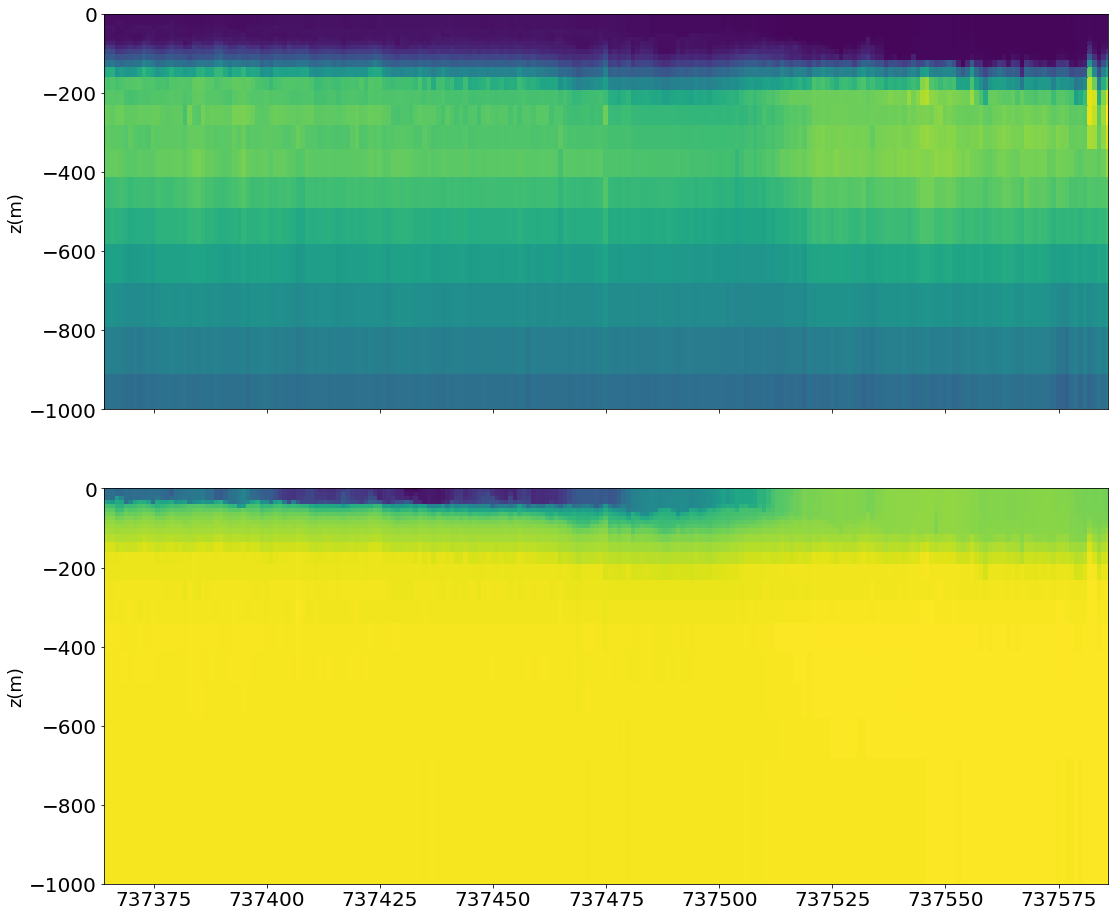

In [164]:
def outlier_moving_average(dates, var, mesh, indices, width):
    
    # initialization
    output = np.copy(var)
    nt = len(dates)
    
    for i in indices:
        # compute moving average in temporal window
        ind1, ind2 = np.max([0, i-width]), np.min([i+width,nt-1])
        jind = np.linspace(ind1,ind2, ind2-ind1+1).astype(int)
        mvar = np.nanmean(var[jind,:],0)
        # compute outlier profile as the mean of the window
        output[i,:] = mvar
        # mask on bottom mesh levels (not accounted for in the computation)
        nlvl = int(mesh.nlevels[i])
        output[i,nlvl+1:] = np.nan
    return output


# process salinity  and temperature outliers
# idea : temporal moving average on a given window
class temporal_extrapolation:
    def __init__(self, data, mesh, width):
        self.dates, self.depth, self.nlevels = data.dates, data.depth, mesh.nlevels
        
        self.salinity, self.temperature = np.copy(data.salinity), np.copy(data.temperature)
        
        self.perform_temporal_extrapolation(data, mesh, width)
        
    def perform_temporal_extrapolation(self, var, mesh, width):
        
        # salinity
        self.salinity = outlier_moving_average(var.dates, var.salinity, mesh, var.indsal, width)
        
        # temperature
        self.temperature = outlier_moving_average(var.dates, var.temperature, mesh, var.indtemp, width)
        
        

#
window_width = 5
data_TE = temporal_extrapolation(data_IV, mesh, window_width)
plot_variables_map(data_TE)

(223, 47)


/tmp/ipykernel_16691/2345989647.py:8: RuntimeWarning: Mean of empty slice
  average[i]=np.nanmean(array[ind1:ind2+1])


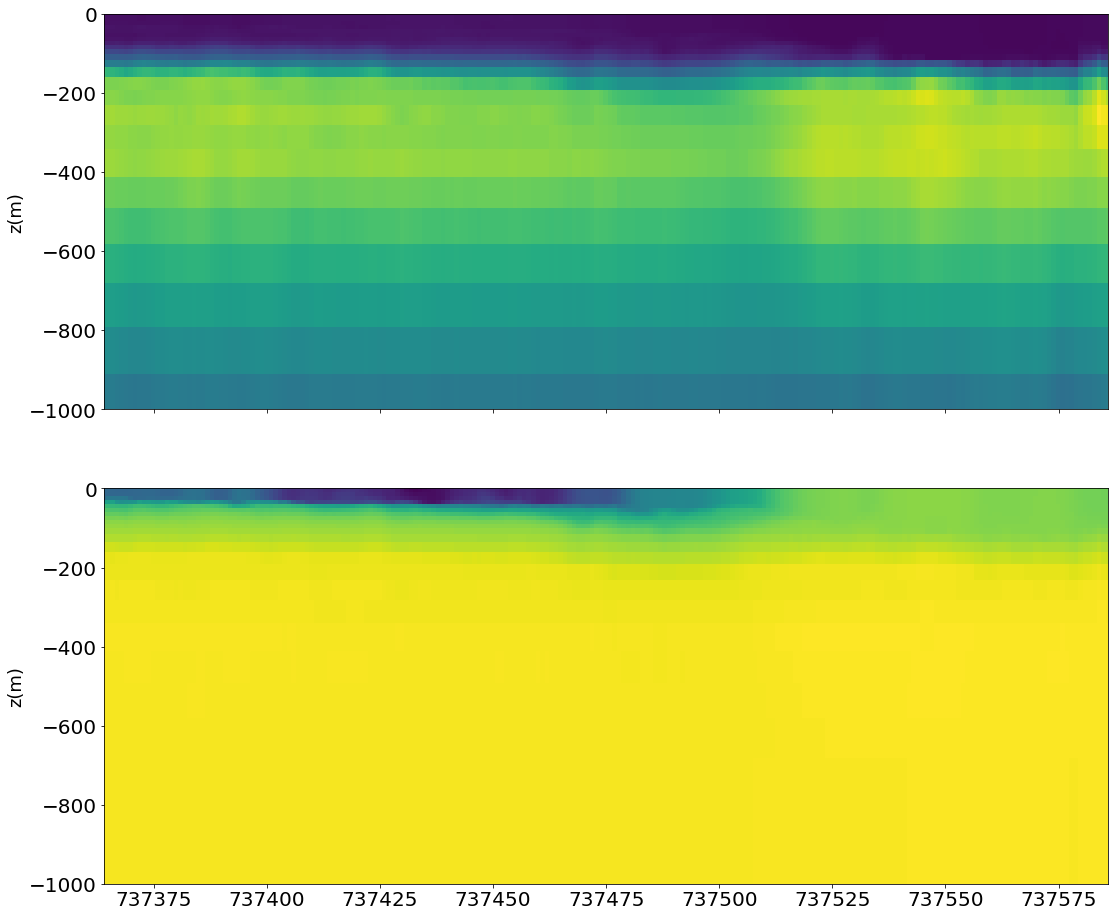

In [163]:
def moving_average_filter(array, window_size):
    # temporal moving average per depth level
    nx=len(array)
    radius=int(np.floor(window_size/2))
    average = np.zeros(len(array))
    for i in range(nx):
        ind1, ind2 = np.max([0,i-radius]), np.min([i+radius,nx-1])
        average[i]=np.nanmean(array[ind1:ind2+1])
    
    return average

class temporal_moving_average:
    def __init__(self, data, width):
        self.dates, self.depth, self.nlevels = data.dates, data.depth, data.nlevels
        
        self.perform_moving_average(data,width)
        
    def perform_moving_average(self,data, width):
        # initialization
        temp, sal = np.zeros(data.salinity.shape), np.zeros(data.temperature.shape)
        print(temp.shape)
        nlvl = len(data.depth)
        
        # perform moving average on each level (salinity, temperature)
        for i in range(nlvl):
                # salinity
                S = data.salinity[:,i]
                index = np.where(np.isnan(S))[0]
                S = moving_average_filter(S, window_size)
                sal[:,i] = S 
                if len(index)>0:
                    sal[index,i] = np.nan
                    
                # temperature
                T = data.temperature[:,i]
                index = np.where(np.isnan(T))[0]
                T = moving_average_filter(T, window_size)
                temp[:,i] = T 
                if len(index)>0:
                    temp[index,i] = np.nan
        self.temperature, self.salinity = temp, sal
        
#
window_size = 5
data_TMA = temporal_moving_average(data_TE, window_size)
plot_variables_map(data_TMA)

/tmp/ipykernel_16691/2655850409.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1, 2, sharey=True)


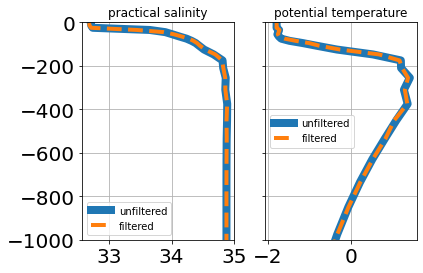

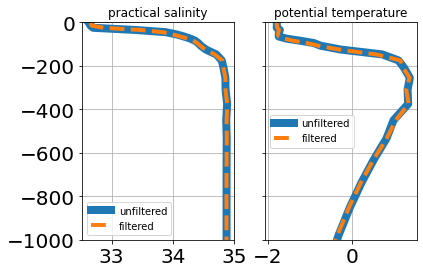

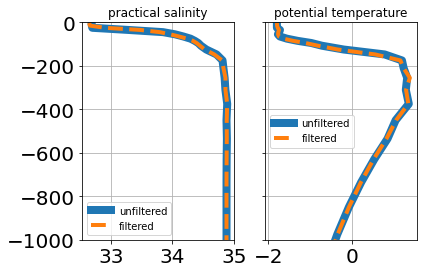

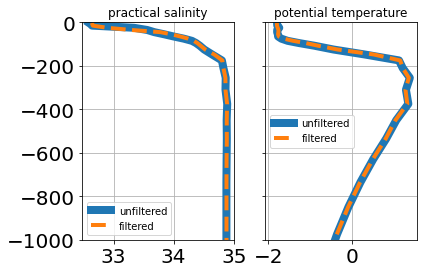

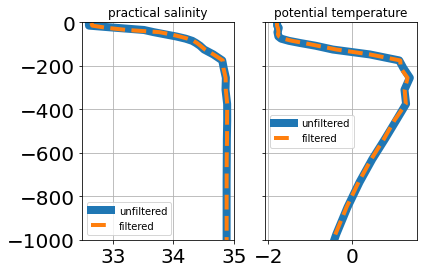

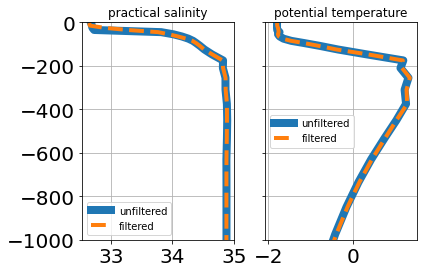

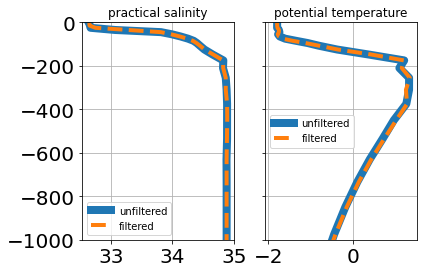

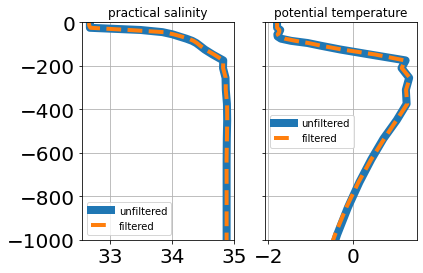

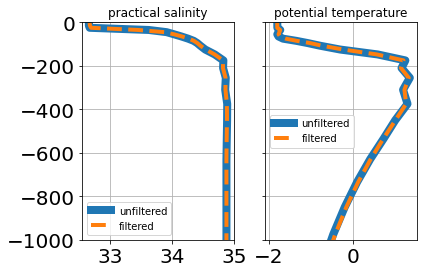

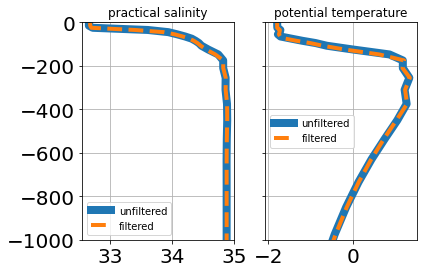

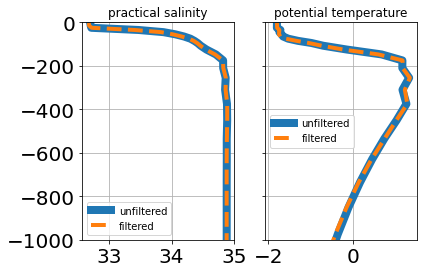

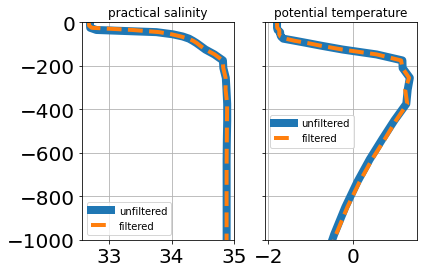

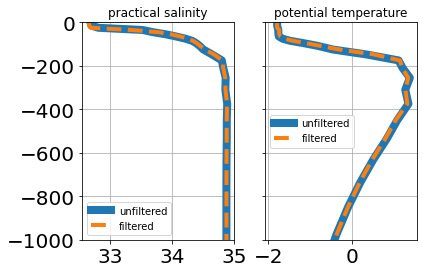

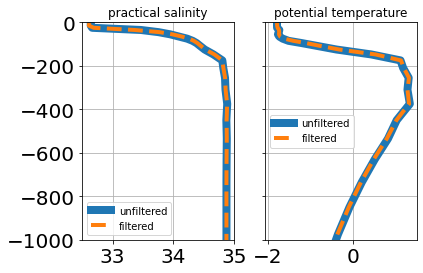

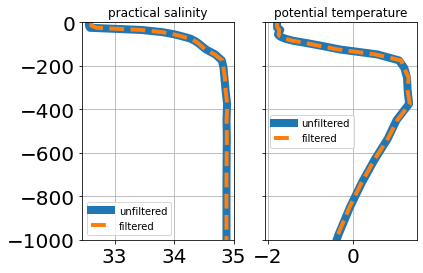

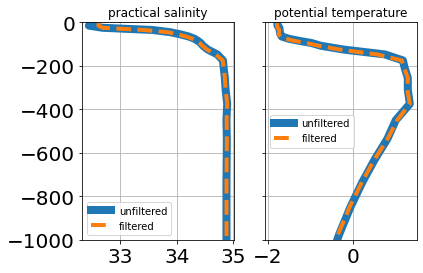

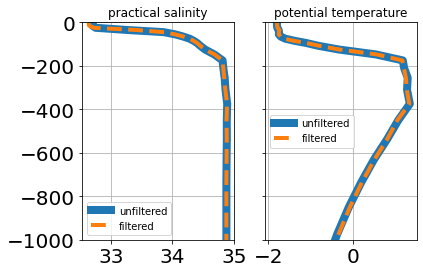

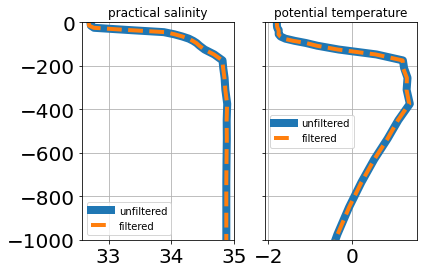

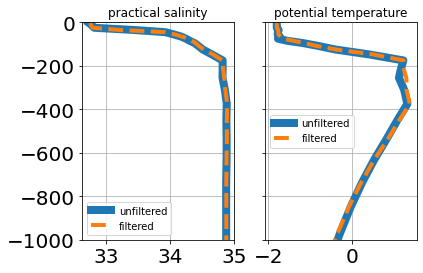

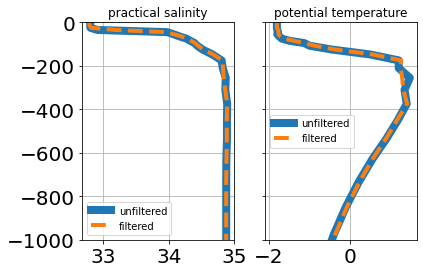

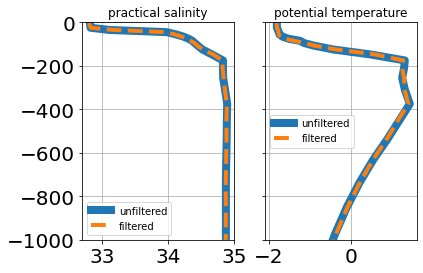

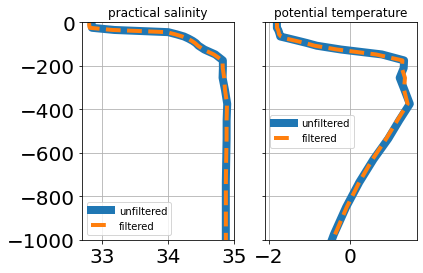

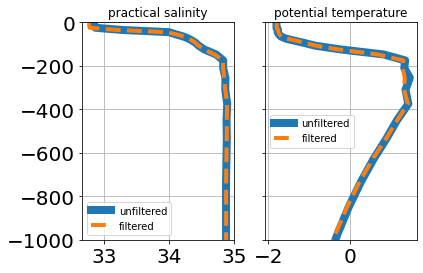

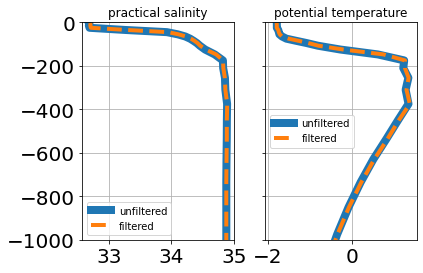

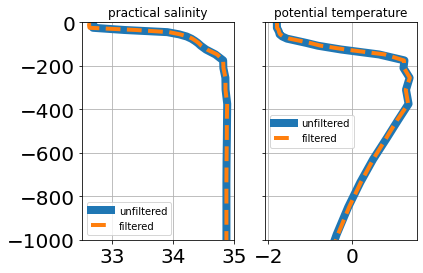

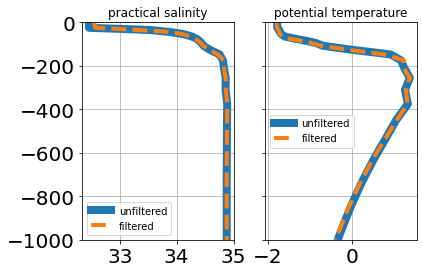

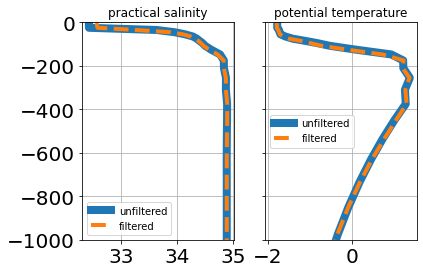

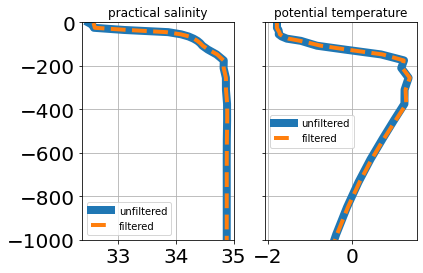

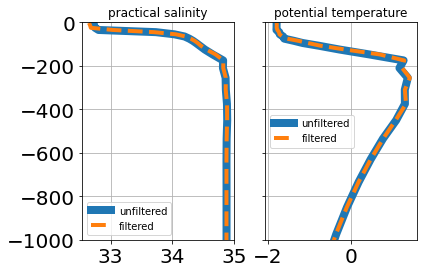

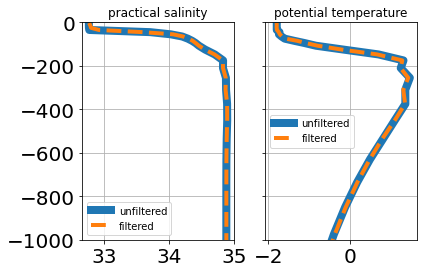

In [160]:
flagplot=True
if (flagplot):
    nt = len(data_TE.dates)
    for i in range(30):
        fig,ax = plt.subplots(1, 2, sharey=True)
        # salinity
        # unfiltered
        ax[0].plot(data_TE.salinity[i,:], data_TE.depth, label='unfiltered', lw=8)
        # filtered
        ax[0].plot(data_TMA.salinity[i,:], data_TMA.depth, label='filtered', lw=4, ls='--')
        ax[0].grid(), ax[0].legend(), ax[0].set_ylim([-1000,0])
        ax[0].set_title('practical salinity')
        #temperature
         # unfiltered
        ax[1].plot(data_TE.temperature[i,:], data_TE.depth, label='unfiltered', lw=8)
        # filtered
        ax[1].plot(data_TMA.temperature[i,:], data_TMA.depth, label='filtered', lw=4, ls='--')
        ax[1].grid(), ax[1].legend(), ax[1].set_ylim([-1000,0])
        ax[1].set_title('potential temperature')
           

In [161]:
class Output(object):
    def __init__(self, filename, data):
        self.write_ocn_forcing(filename, data)
    
    def write_ocn_forcing(self,filename, data):
        #------------------------------------------------------------------------
        # write ITP salinity and temperature profile to netcdf
        #------------------------------------------------------------------------	
    
        # open file
        ncid = Dataset(filename, "w", format="NETCDF4")

        # define dimension
        nt, nlvl = len(data.dates), len(data.depth)
    
        ncid.createDimension('time', nt)
        ncid.createDimension('levels', nlvl)
        dimt, dimlvl, dim = ('time'), ('levels'), ('levels','time') 
        
        # create variable
        dat = ncid.createVariable('dates', "f8", dimt)
        D, nlev = ncid.createVariable('depth', "f8",dimlvl), ncid.createVariable('nlevels', "f8",dimt)
        sal, temp = ncid.createVariable('salinity', "f8",dim), ncid.createVariable('temperature', "f8",dim)

        
        # define units
        dat.units, dat.description = 'days', 'days since '+ str(datetime.fromordinal(int(data.dates[0])))
        D.units, nlev.units = 'm', ''
        sal.units, temp.units = 'PSU', 'degC' 
        sal.long_name, temp.long_name = 'practical salinity', 'potential temperature'
        #fill variables
        ncid['dates'][:] = data.dates
        ncid['depth'][:], ncid['nlevels'][:] = data.depth, data.nlevels 
        ncid['salinity'][:], ncid['temperature'][:] = data.salinity.T, data.temperature.T
   
        # close file
        ncid.close()
#
# write to data to netcdf
path_data = '/home/fbirrien/NuArctic/nuarctic/Data_Processing/'
filename = path_data + 'ITP_data_daily_exponential.nc'
print (filename, dir(data_TE))

# ITP unfiltered data
Output(filename, data_TE)

# ITP filtered data (moving average)
filename=filename.replace('daily','daily_filtered')
Output(filename, data_TMA)

/home/fbirrien/NuArctic/nuarctic/Data_Processing/ITP_data_daily_exponential.nc ['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'dates', 'depth', 'nlevels', 'perform_temporal_extrapolation', 'salinity', 'temperature']
